Contribuidores do Projeto:

Otávio Lira Neves -
* https://www.instagram.com/lira.cod/
* https://www.linkedin.com/in/otavioliraneves

Matheus Oliveira de Andrade

Leonardo Vaidotas de Araujo
* https://www.linkedin.com/in/leonardo-vaidotas-de-araujo-1b7680282/

# Diagóstico de Pneumonia por imagem

![]( https://conteudo.imguol.com.br/c/entretenimento/6e/2020/07/11/radiografia-pulmao-raio-x-1594480928712_v2_1133x926.jpg)

## Contexto

A radiografia de tórax normal (painel esquerdo) mostra pulmões limpos, sem áreas de opacificação anormal na imagem. A pneumonia bacteriana (meio) normalmente exibe uma consolidação lobar focal, neste caso no lobo superior direito (setas brancas), enquanto a pneumonia viral (direita) se manifesta com um padrão “intersticial” mais difuso em ambos os pulmões.

![](https://www.cell.com/cms/attachment/538d3845-028b-4666-af36-7fba78c5c774/figs6.jpg)

## Sobre os dados

O conjunto de dados é organizado em 3 pastas (train, test, val) e contém subpastas para cada categoria de imagem (Pneumonia/Normal). São 5.863 imagens de Raios X (JPEG) e 2 categorias (Pneumonia/Normal).

Imagens de radiografia de tórax (ântero-posterior) foram selecionadas de pacientes pediátricos de um a cinco anos de idade do Centro Médico Feminino e Infantil de Guangzhou, Guangzhou. Todas as radiografias de tórax foram realizadas como parte do atendimento clínico de rotina dos pacientes.

Para a análise das imagens de radiografia de tórax, todas as radiografias de tórax foram inicialmente examinadas para controle de qualidade, removendo todos os exames de baixa qualidade ou ilegíveis. Os diagnósticos das imagens foram então avaliados por dois médicos especialistas antes de serem liberados para o treinamento do sistema de IA. Para compensar eventuais erros de classificação, o conjunto de avaliação também foi verificado por um terceiro especialista.


## Desafio

Neste desafio, você foi selecionado para desenvolver um sistema de diagnóstico automático de Pneumonia a partir de imagens de Radiografias de pacientes de um hostpital. Siga as instruções deste Notebook até atingir o seu seu objetivo final: Uma Rede Neural Convolucional para classificar as imagens em duas classes: Pneumonia e Normal. Boa sorte! 🖖  

Importação de todas as bibliotecas necessarias

In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlopen
from PIL import Image
from google.colab.patches import cv2_imshow
import os
from tqdm import tqdm
import pandas as pd
import shutil

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist, cifar10 #this library contains a lot of ML datasets including the MNIST one
import pickle #pickle is a library that helps us save a lot of different types of data - anything ranging from Pandas dataframes to TensorFlow models
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Conv3D, MaxPooling3D, Input
from tensorflow.keras import Sequential, optimizers, Model, utils
from tensorflow.keras.activations import sigmoid
from sklearn import metrics
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Funções para avaliar e visualizar os modelos

get_predictions: obtem previsões de um modelo treinad

*   Essa função recebe três argumentos: 'model'(o modelo treinado), 'iterador'(um interador que fornece os dados de entrada) e 'device'(o dispositivo de computação, como CPU ou GPU)
*   As imagens, rótulos verdadeiros e probabilidades previstas são armazenados em listas separadas.
*   No final, as listas são concatenadas ao longo da dimensão apropriada e retornadas como tensores

plot_confusion_matrix: plota uma matrix de confusão para avaliar o desempenho do modelo

*   Essa função recebe dois argumentos: 'labels'(rótulos verdadeiros) e 'pred_labels'(rótulos previstos pelo modelo)
*   Ela cria uma figura e um subplot para plotar a matriz de confusão
*   A matriz de confusão é calculada usando 'metrics.confusion_matrix' da biblioteca scikitlearn
*   A matriz de confusão é então plotada usando 'metrics.ConfusionMatrixDisplay' com algumas configurações de exibição como o formato dos valores e o esquema



In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(2))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

## Carregando o dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [ ]:
#contando quantas imagens temos de pessoas com Pneumonia e sem pneumonia
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [ ]:
#codificando os labels em 0 e 1
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
#dividindo os dados em treino e validação.
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [ ]:
#visualizando o shape das imagens
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [ ]:
#carregando e formatando os dados de teste
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## Visuaizando algumas amostras de imagens

In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
label_batch

<tf.Tensor: shape=(64,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
      dtype=int32)>

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

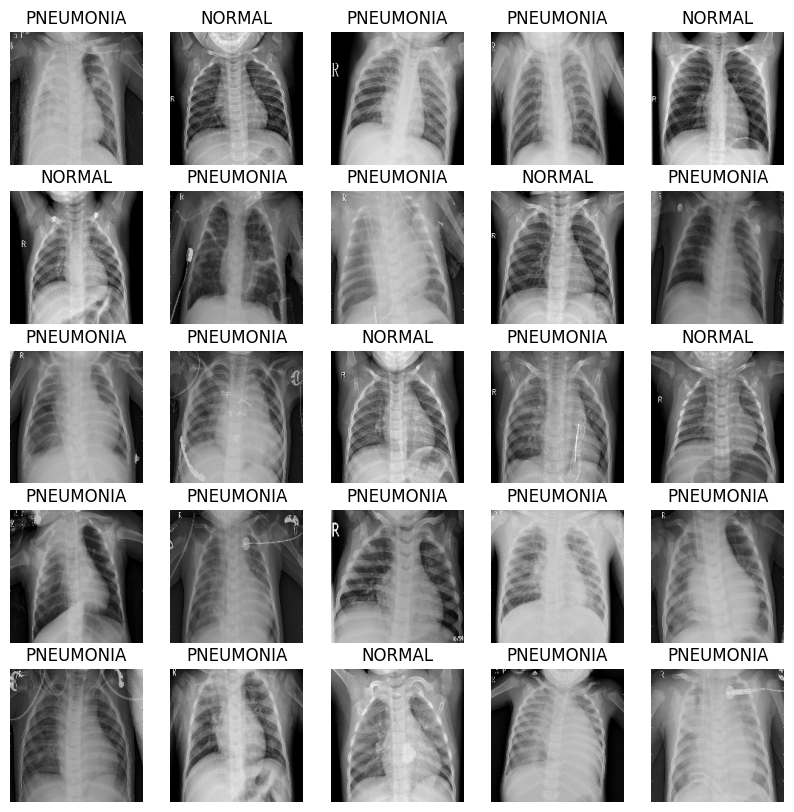

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Criando um modelo de CNN

In [ ]:
model = Sequential()
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))# Input layer
model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsizing images
model.add(Flatten()) # images are 3d so have to flatten them into a (1 x 784) vector
model.add(Dense(256, activation=tf.nn.relu, use_bias=True)) # adding a Dense layer of 128 neurons with relu
model.add(Dropout(0.2)) #Implementing dropout regularization with p = 0.5
model.add(Dense(128, activation=tf.nn.relu, use_bias=True))
model.add(Dropout(0.1))
model.add(Dense(64, activation=tf.nn.relu, use_bias=True))
model.add(Dropout(0.1))
model.add(Dense(1,activation=tf.nn.sigmoid)) # adding an output layer (with 10 possible outputs for the 10 digits we need to predict)

In [ ]:
early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True
)
optimizer=Adam(learning_rate=0.01)
METRICS = [
        BinaryAccuracy(),
        Precision(name="precision"),
        Recall(name="recall"),
    ]

In [ ]:
# compilando o modelo
model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=METRICS,
    )

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping_cb],
)

Epoch 1/10
66/66 [==============================] - 361s 3s/step - loss: 536.4138 - binary_accuracy: 0.8002 - precision: 0.8617 - recall: 0.8697 - val_loss: 0.2807 - val_binary_accuracy: 0.8934 - val_precision: 0.9080 - val_recall: 0.9530
Epoch 2/10
66/66 [==============================] - 3s 44ms/step - loss: 0.2830 - binary_accuracy: 0.8914 - precision: 0.9048 - recall: 0.9537 - val_loss: 0.2366 - val_binary_accuracy: 0.9264 - val_precision: 0.9539 - val_recall: 0.9465
Epoch 3/10
66/66 [==============================] - 3s 45ms/step - loss: 0.2381 - binary_accuracy: 0.9155 - precision: 0.9380 - recall: 0.9485 - val_loss: 0.1498 - val_binary_accuracy: 0.9419 - val_precision: 0.9707 - val_recall: 0.9504
Epoch 4/10
66/66 [==============================] - 3s 48ms/step - loss: 0.1822 - binary_accuracy: 0.9433 - precision: 0.9662 - recall: 0.9569 - val_loss: 0.1497 - val_binary_accuracy: 0.9496 - val_precision: 0.9710 - val_recall: 0.9608
Epoch 5/10
66/66 [==============================] 

## 1- Adicione mais camadas convolucionais e responda as seguintes questões:

a) O modelo melhorou ou piorou? Por quê?

b) Compare as curvas de aprendizado deste modelo com o modelo treinado anteriormente

c) Na sua opinião, este modelo está bom ou pode ser melhorado? Caso ele possa ser melhorado, apresente sugestões para melhorá-lo.

In [ ]:
def plot_history(history):
    acc = history.history['precision']
    val_acc = history.history['val_precision']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 10))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training precision')
    plt.plot(x, val_acc, 'r', label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')

In [ ]:
model = Sequential()
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))# Input layer
model.add(Conv2D(16, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2))) # downsizing images
model.add(Conv2D(11, 3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(3, 3))) # downsizing images
model.add(Flatten()) # images are 3d so have to flatten them into a (1 x 784) vector
model.add(Dense(256, activation=tf.nn.relu, use_bias=True)) # adding a Dense layer of 128 neurons with relu
model.add(Dropout(0.2)) #Implementing dropout regularization with p = 0.5
model.add(Dense(128, activation=tf.nn.relu, use_bias=True))
model.add(Dropout(0.1))
model.add(Dense(64, activation=tf.nn.relu, use_bias=True))
model.add(Dropout(0.1))
model.add(Dense(1,activation=tf.nn.sigmoid)) # adding an output layer (with 10 possible outputs for the 10 digits we need to predict)

In [ ]:
early_stopping_cb = EarlyStopping(
    patience=10, restore_best_weights=True
)
optimizer=Adam(learning_rate=0.01)
METRICS = [
        BinaryAccuracy(),
        Precision(name="precision"),
        Recall(name="recall"),
    ]

In [ ]:
# compilando o modelo
model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=METRICS,
    )

In [ ]:
history2 = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping_cb],
)

Epoch 1/10
66/66 [==============================] - 6s 44ms/step - loss: 4.2694 - binary_accuracy: 0.8252 - precision: 0.8785 - recall: 0.8864 - val_loss: 0.3368 - val_binary_accuracy: 0.8866 - val_precision: 0.8952 - val_recall: 0.9595
Epoch 2/10
66/66 [==============================] - 3s 42ms/step - loss: 0.3027 - binary_accuracy: 0.8767 - precision: 0.9268 - recall: 0.9048 - val_loss: 0.2150 - val_binary_accuracy: 0.9079 - val_precision: 0.9397 - val_recall: 0.9360
Epoch 3/10
66/66 [==============================] - 2s 37ms/step - loss: 0.2463 - binary_accuracy: 0.8945 - precision: 0.9437 - recall: 0.9118 - val_loss: 0.2052 - val_binary_accuracy: 0.9196 - val_precision: 0.9350 - val_recall: 0.9582
Epoch 4/10
66/66 [==============================] - 2s 36ms/step - loss: 0.2382 - binary_accuracy: 0.9007 - precision: 0.9430 - recall: 0.9215 - val_loss: 0.1956 - val_binary_accuracy: 0.9244 - val_precision: 0.9599 - val_recall: 0.9373
Epoch 5/10
66/66 [==============================] - 

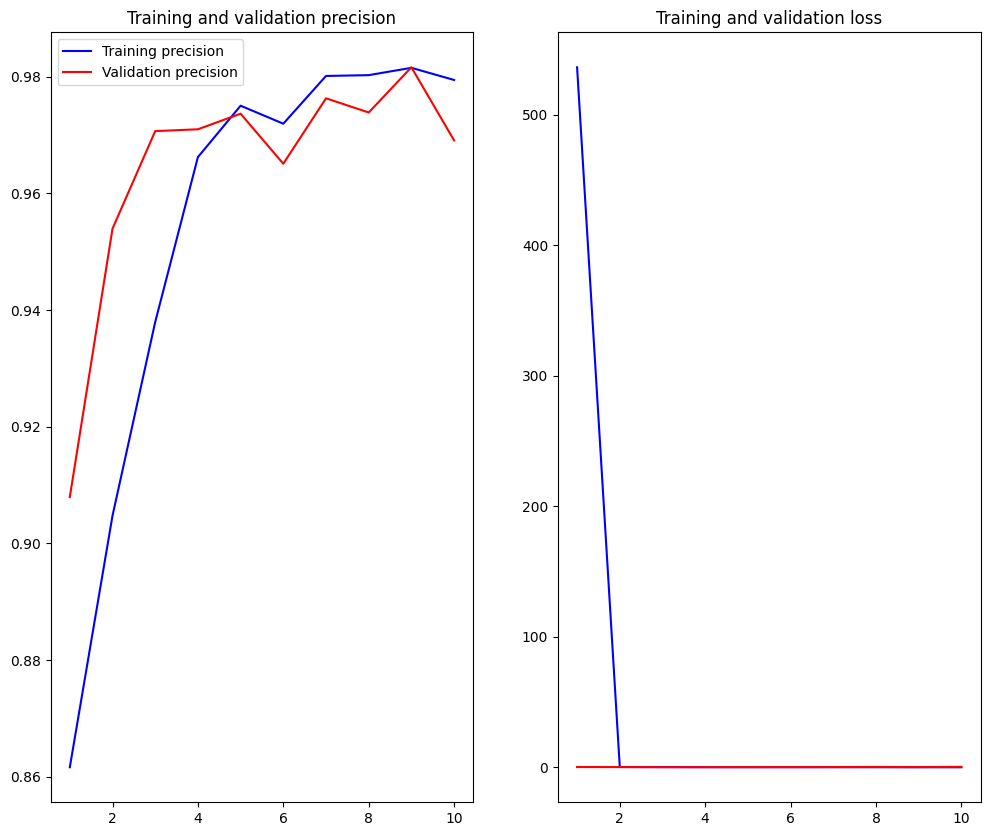

In [ ]:
plot_history(history)

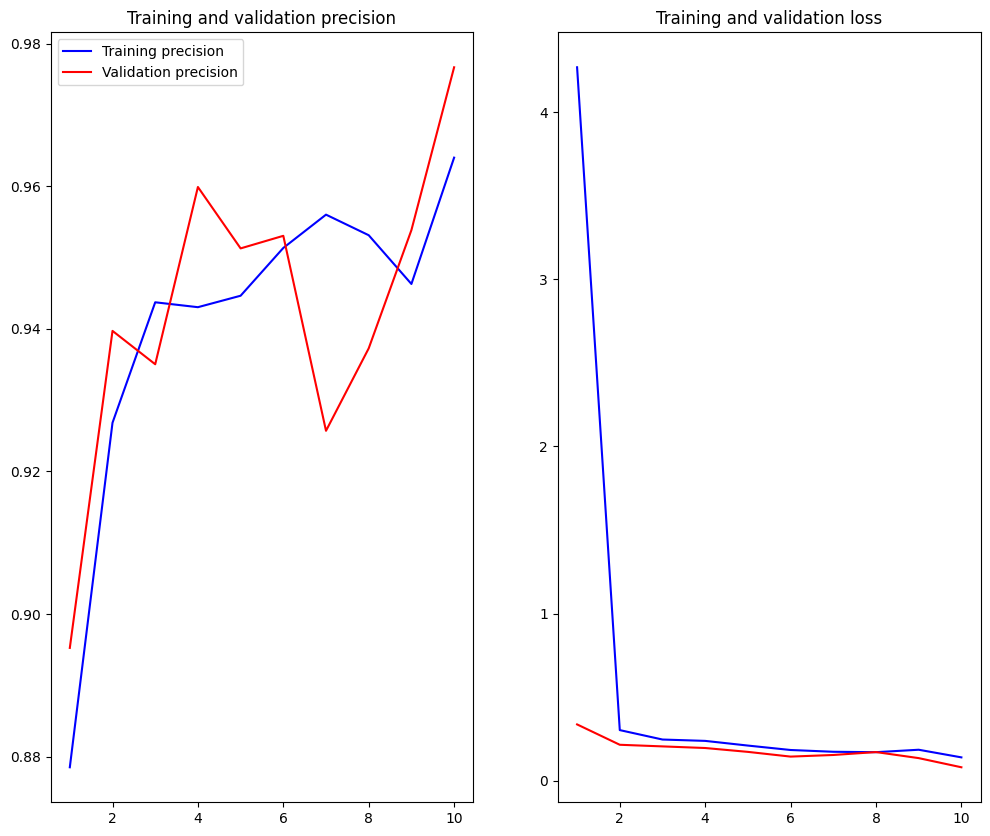

In [ ]:
plot_history(history2)

A) O modelo piorou, o motivo depende, existe vários fatores que podem melhorar ou piorar o desempenho, como a complexidade do conjunto de dados, o tamanho e a profundidade da arquitetura da rede neural

B) as curvas de treinamento e precisão mostram uma perca

C) Atualmente não encontramos outra forma de melhorar o modelo, mas ainda abre espaço para melhorias futuras

## 2- Visualize o resultado dos filtros aprendidos pela última camada convolucional do seu modelo aplicando-o em algumas imagens. Apresente a sua interpretação dos resultados


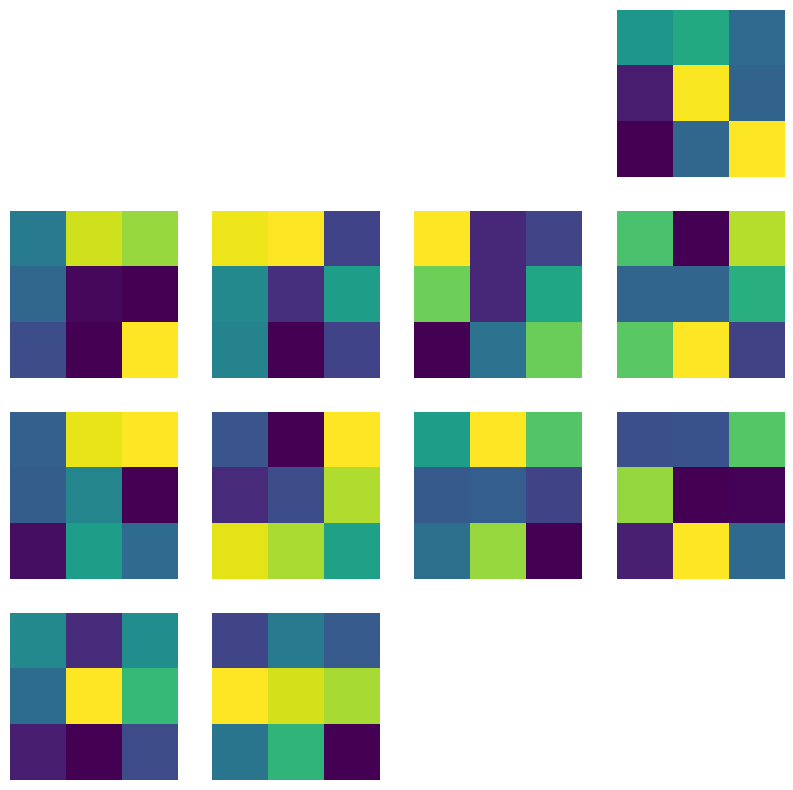

In [ ]:
ultima_camada = model.get_layer("conv2d_2")
pesos = ultima_camada.get_weights()[0]

pesos_normalizados = (pesos - np.min(pesos)) / (np.max(pesos) - np.min(pesos))

plt.figure(figsize=(10,10))
for i in range(pesos_normalizados.shape[-1]):
  plt.subplot(4, 4, i + 4)
  plt.imshow(pesos_normalizados[:, :, 0, i], cmap="viridis")
  plt.axis("off")
plt.show()

##3- Faça um gráfico com a matriz de confusão para o dataset de teste e responda a seguinte pergunta: É seguro utilizar este modelo para substituir um diagnóstico feito por um médico humano? Apresente sugestões de como o médico/hospital poderia utilizá-lo de forma segura no seu dia-a-dia.

In [ ]:
# Fazendo previsões no conjunto de teste
test_images, test_labels, test_probs = get_predictions(model, test_ds, 'cpu')

# Obtendo rótulos previstos
predicted_labels = (test_probs > 0.5).astype(np.int)

# Plotando a matriz de confusão
plot_confusion_matrix(test_labels, predicted_labels)

AttributeError: 'Sequential' object has no attribute 'eval'

Apesar da IA ser precisa e ser muito útil, devemos considerar e a IA é uma ferramente complementar e não substitutiva.
E melhor que os médicos usem o modelo como uma ferramenta de suporte auxiliar em seus diagnosticos, sendo é claro necessário treinar com vários conjuntos diferentes de dados, realizar testes clínicos controlados e garantir que os medicos recebam treinamento adequado sobre como interpretar e usar os resultados dos modelos de maneira ética e responsável  